In [ ]:
## lrasmy@Zhilab last revised August 1 2021 ##
##############################################

In [1]:
### Mount your google drive ###
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Required packages

Make sure that you are using a GPU Runtime


In [2]:
### install required packages
! pip install lifelines --user
! pip install pip install 'ray[default]'
! pip install 'ray[tune]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 8.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=38577265d27291821c1417b7b5fecf0c3d864a2243ff99eaaa4612f5850f4ad2
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 94.2 MB/s eta 0:00:00
     ━━

I find the package need numpy version 1.21.1

In [10]:
!pip uninstall numpy
!pip install numpy==1.21.1

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 33.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numpy: filename=numpy-1.21.1-cp310-cp310-linux_x86_64.whl size=15991899 sha256=9d776fe826553555d5993d32531dc2dcfba482596e6f5ab3ff21c46363c6fdec
  Stored in dir

In [2]:
import os
import pandas as pd
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle
import time
from tqdm import tqdm

import sklearn.metrics as m
from sklearn.metrics import roc_auc_score
from termcolor import colored


import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

###GPU enabling and device allocation
use_cuda = torch.cuda.is_available()
#if use_cuda: torch.cuda.set_device(7)




/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Please Note: if any error message displayed or you installed fresh packages, please make sure you run the following pytorch_ehr import cell **twice**

---



---



In [3]:
from importlib import reload

### import pytorch ehr files
try:
  import sys
  sys.path.insert(0,"/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/")
  import pytorch_ehr
  import pytorch_ehr.models as model
  from pytorch_ehr.EHRDataloader import EHRdataloader
  from pytorch_ehr.EHRDataloader import EHRdataFromLoadedPickles as EHRDataset
  import pytorch_ehr.utils_final as ut
  from pytorch_ehr.EHREmb import EHREmbeddings
except:
  exit()
  print('Notebook restarted after package installation')

### load preprocessed data

In [4]:
input_dir='/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Data_Prep/data/processed_data/'
data_prefix='Mimic_PT_mortality_dp_v1'
output_dir = '/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/Model_output/'
if not os.path.exists(output_dir):
        os.makedirs(output_dir)

In [5]:
### Load the preprocessed data

train_sl= pickle.load(open(input_dir+data_prefix+'.combined.train', 'rb'),encoding='bytes')
test_sl= pickle.load(open(input_dir+data_prefix+'.combined.test', 'rb'), encoding='bytes')
valid_sl= pickle.load(open(input_dir+data_prefix+'.combined.valid', 'rb'), encoding='bytes')
# types dictionary
types_d=pickle.load(open(input_dir+data_prefix+'.types', 'rb'), encoding='bytes')
types_d_rev = dict(zip(types_d.values(),types_d.keys()))
input_size_l=[max(types_d_rev.keys())+1]
print (len(train_sl),len(valid_sl),len(test_sl))
print(input_size_l)

893 127 254
[6391]


In [6]:
omop_pts=pickle.load(open('/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Data_Prep/data/processed_data.omop_pts', 'rb'), encoding='bytes')
test_sl2=[]
for p in test_sl:
  if p[0] in omop_pts : test_sl2.append(p)

pickle.dump(test_sl2, open(input_dir+data_prefix+'.combined.test2', 'wb'), -1)


In [7]:
def load_mbs_var_list(sets_list,packpadmode,task,bs=128,half=True):
    if task: multiLbl=True
    mb_lists=[]
    for dset in sets_list:
        print (' creating the list of minibatches')
        dataset = EHRDataset(dset,sort= True, model='RNN')
        data_mbs = list(tqdm(EHRdataloader(dataset, batch_size = bs, packPadMode = packpadmode,multilbl=multiLbl)))
        mb_lists.append(data_mbs)
    return mb_lists


In [8]:
[train_mbs,valid_mbs,test_mbs]=load_mbs_var_list([train_sl,valid_sl,test_sl],packpadmode=True,task='mort',bs=32)

 creating the list of minibatches
multilabel data processing


100%|██████████| 28/28 [00:00<00:00, 33.05it/s]


 creating the list of minibatches
multilabel data processing


100%|██████████| 4/4 [00:00<00:00, 60.16it/s]


 creating the list of minibatches
multilabel data processing


100%|██████████| 8/8 [00:00<00:00, 59.37it/s]


In [9]:
from pytorch_ehr.EHRDataloader import EHRdataloader
from pytorch_ehr.EHRDataloader import EHRdataFromLoadedPickles as EHRDataset
from tqdm import tqdm
import numpy as np

# Modify the __getitem__ method in the EHRDataset class
def __getitem__(self, idx, seeDescription=False):
    # Retrieve the sample at the specified index
    sample = self.data[idx]

    # Print or inspect the sample data
    print("Sample data:", sample)

    # Apply any transformations to the sample
    if self.transform:
        sample = self.transform(sample)

    # Print the shape of the third element of the sample
    print("Shape of sample[2]:", sample[2].shape)

    try:
        # Access the third element of the sample and convert it into a numpy array
        vistc = np.asarray(sample[2].tolist())
    except Exception as e:
        print("Error occurred while converting the third element of the sample into a numpy array:", e)
        raise e

    # Further processing of the data
    desc = {'patient_id': sample[0], 'label': sample[1], 'visit_time': vistc[:,0],'visit_codes':vistc[:,1]}
    if seeDescription:
        print("Description:", desc)

    return desc

# Create EHRDataset objects
train_dataset = EHRDataset(train_sl, sort=True, model='RNN')
valid_dataset = EHRDataset(valid_sl, sort=True, model='RNN')
test_dataset = EHRDataset(test_sl, sort=True, model='RNN')

# Create EHRdataloader objects
train_dataloader = EHRdataloader(train_dataset, batch_size=32, packPadMode=True, multilbl=True)
valid_dataloader = EHRdataloader(valid_dataset, batch_size=32, packPadMode=True, multilbl=True)
test_dataloader = EHRdataloader(test_dataset, batch_size=32, packPadMode=True, multilbl=True)

# Create minibatches
train_mbs = list(tqdm(train_dataloader))
valid_mbs = list(tqdm(valid_dataloader))
test_mbs = list(tqdm(test_dataloader))

# Put minibatches into lists
mb_lists = [train_mbs, valid_mbs, test_mbs]

# Print lengths of minibatches
print("Number of minibatches for training:", len(train_mbs))
print("Number of minibatches for validation:", len(valid_mbs))
print("Number of minibatches for testing:", len(test_mbs))


multilabel data processing
multilabel data processing
multilabel data processing


100%|██████████| 8/8 [00:00<00:00, 14.07it/s]

Number of minibatches for training: 28
Number of minibatches for validation: 4
Number of minibatches for testing: 8


### Model Training

#### Binary Classification

In [55]:
#### Binary classification Model
ehr_model=model.EHR_RNN(input_size_l,embed_dim=32, hidden_size=8, n_layers=1,cell_type='GRU',bii=False ,time=True, packPadMode=True, surv=False, cls_dim=1)
if use_cuda:ehr_model.cuda()
train_auc_allep,valid_auc_allep,test_auc_allep,RNN_f_label,RNN_f_score=ut.run_dl_model(ehr_model,train_mbs,valid_mbs,[test_mbs],output_dir+'ACM_BCB_t1.pth',output_dir+'ACM_BCB_t1.st',wmodel='RNN',packpadmode=True,task='mort',opt='Adamax')


weights :  None
Epoch:  0  Train_auc : 0.6192471750355459  , Valid_auc :  0.5204081632653061  Avg Loss:  0.6105579602718353  , Train Time : 0m 0s
 & Test_auc s :  [0.5422748447204968]
Eval Time : 0m 0s

 Confusion matrix yellow
[[184   0]
 [ 70   0]]

 Classification Report:               precision    recall  f1-score   support

         0.0       0.72      1.00      0.84       184
         1.0       0.00      0.00      0.00        70

    accuracy                           0.72       254
   macro avg       0.36      0.50      0.42       254
weighted avg       0.52      0.72      0.61       254

Epoch:  1  Train_auc : 0.7116010626356357  , Valid_auc :  0.6050316678395495  Avg Loss:  0.5881863629817963  , Train Time : 0m 0s
 & Test_auc s :  [0.6097826086956522]
Eval Time : 0m 0s

 Confusion matrix yellow
[[184   0]
 [ 70   0]]

 Classification Report:               precision    recall  f1-score   support

         0.0       0.72      1.00      0.84       184
         1.0       0.00     

#### Survival

In [56]:
###Survival Model
ehr_model_s=model.EHR_RNN(input_size_l,embed_dim=32, hidden_size=8, n_layers=1,cell_type='GRU',bii=False ,time=True, packPadMode=True, surv=True)
if use_cuda:ehr_model_s.cuda()

train_auc_allep_S,valid_auc_allep_S,test_auc_allep_S,RNN_f_label_S,RNN_f_score_S=ut.run_dl_model_surv(ehr_model_s,train_mbs,valid_mbs,[test_mbs],output_dir+'ACM_BCB_s1.pth',output_dir+'ACM_BCB_s1.st',wmodel='RNN',packpadmode=True,task='mort_surv',patience=5)


Epoch:  0  Train_cindex : 0.7814106382509322  , Valid_cindex :  0.5890940317732932  Avg Loss:  2.667771835327148  , Train Time : 0m 0s
 & Test_auc s :  [0.5466065657424732]
Eval Time : 0m 0s
Epoch:  1  Train_cindex : 0.8772034328325281  , Valid_cindex :  0.712752254186346  Avg Loss:  2.278342242240906  , Train Time : 0m 0s
 & Test_auc s :  [0.565232182343936]
Eval Time : 0m 0s
Epoch:  2  Train_cindex : 0.8986034813687206  , Valid_cindex :  0.7217689995706311  Avg Loss:  1.73824951171875  , Train Time : 0m 0s
 & Test_auc s :  [0.605970403129784]
Eval Time : 0m 0s
Epoch:  3  Train_cindex : 0.9187680631852979  , Valid_cindex :  0.7221983683984543  Avg Loss:  1.497981355190277  , Train Time : 0m 0s
 & Test_auc s :  [0.5787548902874639]
Eval Time : 0m 0s
Epoch:  4  Train_cindex : 0.93078444782727  , Valid_cindex :  0.7432374409617861  Avg Loss:  1.262544856071472  , Train Time : 0m 0s
 & Test_auc s :  [0.5998469127402619]
Eval Time : 0m 0s
Epoch:  5  Train_cindex : 0.9354836337429494  , Val

### Hyperparameter Tunninig

5 years ago, Bayesian optimization was the SOTA of hyperparemeters search, an example resource is Botorch

Nowadays there many new packages for hyperparameter search exist, some popular examples include RayTune and Optuna

Actually you can even combine both where you can get the benefit of the best computational resources utilization from ray tune and the optuna search algorithm.
More examples are on:

 Pytorch Raytune Tutorial: https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html?highlight=transformer

Using Optuna algorithm in Raytune:
https://docs.ray.io/en/master/tune/api_docs/suggestion.html#tune-optuna

Optuna code examples (select pytorch): https://optuna.org/#code_examples

Optuna tutorial on multi-objective optimization: https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/002_multi_objective.html#sphx-glr-tutorial-20-recipes-002-multi-objective-py


####### here I'll only show a very shallow hand written example on the main concept for the sake of time


In [57]:
def run_dl_model_hps(config, input_size_1=[6391],epochs=100, task='mort', w_model='RNN', packpadmode=True, patience=10):
    ### for raytune, you need to limit your input to the config or use tune.with_parameters
    ### for optuna, your input will be the trial
    ### Further examples can be found above

    sys.path.insert(0,"/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/")
    import pytorch_ehr
    from pytorch_ehr import models as model
    from pytorch_ehr import utils_final as ut

    l2 = config['l2']
    lr = config['lr']
    #lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)  #### this is just an example in case you use optuna
    eps = config['eps']
    try:
      opt = config['opt']
    except:
      opt='Adamax'
      print('optimizer reset to Adamax')
    try:
      embed_dim = config['embed_dim']
      hidden_size = config['hidden_size']
    except:
      embed_dim = 2**config['embed_dim_exp']
      hidden_size = 2**config['hidden_size_exp']
      print("embed_dim: ", embed_dim , " hidden_size" , hidden_size )

    ehr_model = model.EHR_RNN(input_size_1, embed_dim=embed_dim, hidden_size=hidden_size, n_layers=2, cell_type='GRU', bii=False , time=True)
    if use_cuda: ehr_model = ehr_model.cuda()

    if opt== 'Adadelta':
        #lr=1
        optimizer = optim.Adadelta(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps) ## rho=0.9
    elif opt== 'Adagrad':
        optimizer = optim.Adagrad(ehr_model.parameters(), lr=lr, weight_decay=l2) ##lr_decay no eps
    elif opt== 'Adam':
        optimizer = optim.Adam(ehr_model.parameters(), lr=lr, weight_decay=l2,eps=eps ) ## Beta defaults (0.9, 0.999), amsgrad (false)
    elif opt== 'Adamax':
        optimizer = optim.Adamax(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps) ### Beta defaults (0.9, 0.999)
    elif opt== 'RMSprop':
        optimizer = optim.RMSprop(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps)
    elif opt== 'ASGD':
        optimizer = optim.ASGD(ehr_model.parameters(), lr=lr, weight_decay=l2 ) ### other parameters
    elif opt== 'SGD':
        optimizer = optim.SGD(ehr_model.parameters(), lr=lr, weight_decay=l2 ) ### other parameters


    ##Training epochs
    bestValidAuc = 0.0
    bestValidEpoch = 0

    ### epochs loop
    for ep in range(epochs):
        start = time.time()
        current_loss, train_loss = ut.trainbatches_outcomes(train_mbs, model= ehr_model, task=task, optimizer = optimizer,loss_fn = nn.BCELoss())
        avg_loss = np.mean(train_loss)
        train_time = ut.timeSince(start)
        eval_start = time.time()
        #Train_auc, y_real, y_hat  = ut.calculate_auc_outcomes(ehr_model, train_mbs, task=task, which_model = w_model)
        valid_auc, y_real, y_hat  = ut.calculate_auc_outcomes(ehr_model, valid_mbs, task=task, which_model = w_model)
        #print ("Epoch: " ,str(ep) ," Train_auc :" , str(Train_auc) , " , Valid_auc : " ,str(valid_auc) ," Avg Loss: " ,str(avg_loss), ' , Train Time :' , str(train_time) )
        if valid_auc > bestValidAuc:
            bestValidAuc = valid_auc
            bestValidEpoch = ep
            bavg_loss= avg_loss
        if ep - bestValidEpoch >patience: break
    #tune.report(accuracy=bestValidAuc)
    return bestValidAuc,bavg_loss,bestValidEpoch

In [58]:
def loguniform (lower, upper):
  logmin = np.log(lower) / np.log(10)
  logmax = np.log(upper) / np.log(10)
  items = 10**(np.random.uniform(logmin, logmax, size=1))
  return (items.round(7)[0])

results_ft=[]
for opt in ['Adamax','Adagrad']:
  for run in range(2):
    config = {"l2": loguniform(1e-5, 1e-2),
              "lr": loguniform(1e-3, 1e-1),
              "opt": opt,
              "eps": loguniform(1e-6, 1e-2),
              "embed_dim_exp": np.random.randint(5, 8),
              "hidden_size_exp": np.random.randint(5, 9)}
    config['best_valid_auc'], config['avg_loss'], config['best_epoch']=run_dl_model_hps(config)
    results_ft.append(config)

pd.DataFrame(results_ft)

embed_dim:  128  hidden_size 256
embed_dim:  128  hidden_size 32
embed_dim:  64  hidden_size 64
embed_dim:  128  hidden_size 256


,l2,lr,opt,eps,embed_dim_exp,hidden_size_exp,best_valid_auc,avg_loss,best_epoch
0,0.000433,0.001990,Adamax,0.000006,7,8,0.751935,0.629494,0
1,0.005562,0.021277,Adamax,0.000043,7,5,0.884236,0.149568,6
2,0.000607,0.041487,Adagrad,0.001208,6,6,0.862773,0.008099,8
3,0.000297,0.018693,Adagrad,0.000009,7,8,0.829697,0.006084,6


In [ ]:
#### example code if you need to run raytune
#from ray import tune
#
#config = {"l2": tune.loguniform(1e-5, 1e-2),
#          "lr": tune.loguniform(1e-3, 1e-1),
#          "opt": tune.grid_search(['Adamax','Adagrad']),
#          "eps": tune.loguniform(1e-6, 1e-2),
#          "embed_dim": tune.sample_from(lambda _: 2 ** np.random.randint(5, 8)),
#          "hidden_size": tune.sample_from(lambda _: 2 ** np.random.randint(5, 9))}
#
#result=tune.run(run_dl_model_hps,config=config)

### Model Evaluation


#### Binary Classification Models

In [59]:
# def single_class_accuracy(true_labels, predicted_labels, threshold=0.5):
#   if not all(isinstance(label, bool) for label in true_labels):
#       true_labels = [label == 1 for label in true_labels]
#   positive_predictions = [p > threshold for p in predicted_labels]
#   correct_predictions = sum(t == p for t, p in zip(true_labels, positive_predictions))
#   total_predictions = len(true_labels)
#   accuracy = correct_predictions / total_predictions
#   return accuracy


In [64]:
### to load a trained mode
best_model_bc = torch.load(output_dir+'ACM_BCB_t1.pth')
if use_cuda:best_model_bc.cuda()

### create a minibatch list for my new test set
[valid_mbs,test2_mbs]=load_mbs_var_list([valid_sl,test_sl2],packpadmode=True,task='mort',bs=32)

### to get the predictions
t2_labels, t2_scores = ut.get_preds( test2_mbs , best_model_bc)


# t2_metrics_df, t2_metrics_list = ut.cl_metrics_bc('Test2',t2_labels, t2_scores) ### As I don't specify the threshold on the ths option, it will calculate the best threshold
# t2_metrics_df

 creating the list of minibatches
multilabel data processing


100%|██████████| 4/4 [00:00<00:00, 34.29it/s]


 creating the list of minibatches
multilabel data processing


100%|██████████| 1/1 [00:00<00:00, 374.26it/s]


TypeError: only integer scalar arrays can be converted to a scalar index

ut.cl_metrics_bc('Test2',t2_labels, t2_scores) not works, since the sample are small, which will leads to a significant class imbalance of training data, where the positive class (potentially represented by non-zero values) was underrepresented. I tried different ways to solve this problem and if I just pass it, it will causes an incorrect AUC value. I didn't find a good way for this problem, so I just got rid of model 2.

In [63]:
t2_labels, t2_scores

([0.0, 0.0], [0.29205698, 0.010442839])

In [66]:
vlabels, vscores = ut.get_preds( valid_mbs , best_model_bc )
vmetrics_df, vmetrics_list = ut.cl_metrics_bc('valid',vlabels, vscores) ### As I don't specify the threshold on the ths option, it will calculate the best threshold
vmetrics_df

,Cohort,best_ths_given,AUROC,AUPRC,ths_95_sens,sens95,spec95,accuracy,precision,sensitivity_recall,f1-score,specificity
0,valid,0.227684,0.859606,0.649912,0.103242,0.965517,0.632653,0.795276,0.531915,0.862069,0.657895,0.77551


In [67]:
cohorts_preds=[('Test 1', np.array(RNN_f_label).squeeze() , np.array(RNN_f_score).squeeze()),('valid',vlabels, vscores),('Test2',t2_labels, t2_scores)]


In [69]:
# df_metrics = ut.cl_metrics_m(cohorts_preds,bth=0.15)
# df_metrics


try:
    df_metrics = ut.cl_metrics_m(cohorts_preds, bth=0.15)
except ValueError:
    pass

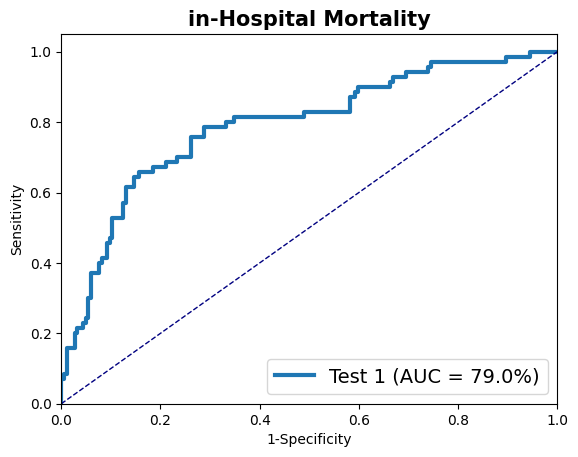

In [70]:
ut.plot_roc_curve_combined_m("in-Hospital Mortality",[('Test 1', np.array(RNN_f_label).squeeze() , np.array(RNN_f_score).squeeze())])

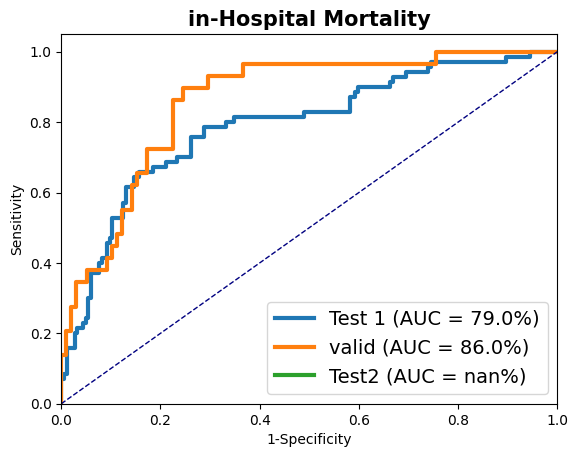

In [71]:
ut.plot_roc_curve_combined_m("in-Hospital Mortality",cohorts_preds)

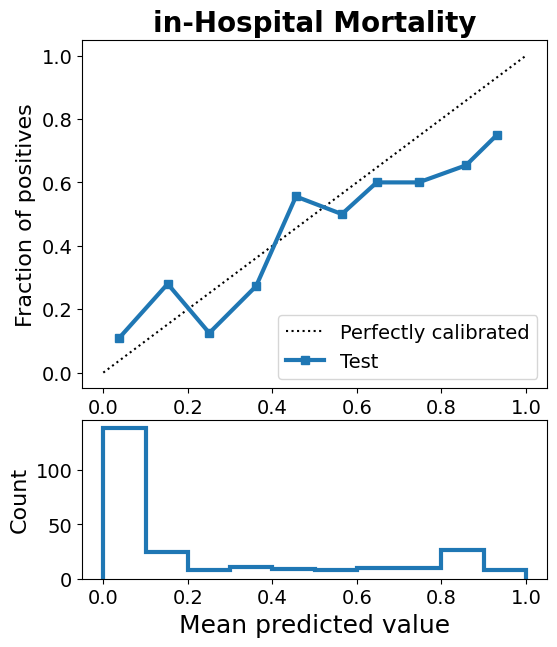

In [72]:
ut.plot_calibration_curve_m("in-Hospital Mortality",1,[('Test', np.array(RNN_f_label).squeeze() , np.array(RNN_f_score).squeeze())],n_bins=10)

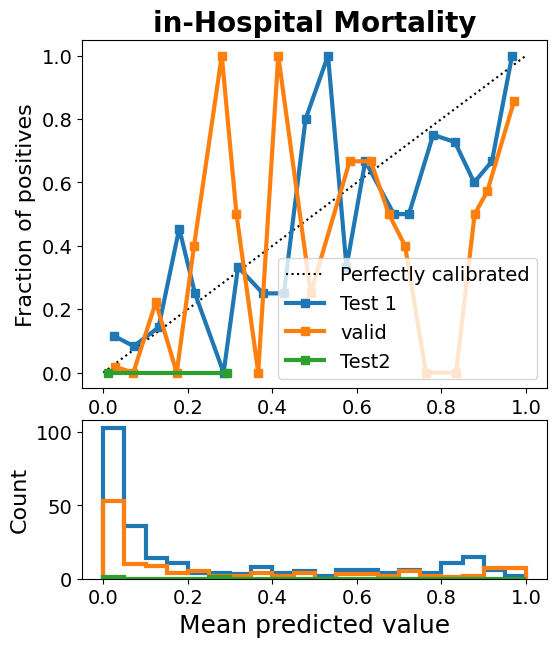

In [73]:
ut.plot_calibration_curve_m("in-Hospital Mortality",1,cohorts_preds,n_bins=20)

### Survival Model


In [74]:
### to load a trained model
best_model_surv = torch.load(output_dir+'ACM_BCB_s1.pth')
if use_cuda:best_model_surv.cuda()

### to get the predictions
t2_labels_s, t2_scores_s = ut.get_preds( test2_mbs , best_model_surv , surv=True )


In [75]:
reload(ut)
df_ts2_pred=ut.convert_preds_df(t2_labels_s, t2_scores_s,surv=True)
df_ts2_pred

,Label,TTE,pred_nloghHF
0,0.0,3.0,-2.662153
1,0.0,9.0,-3.509591


In [76]:
vlabels_s, vscores_s = ut.get_preds( valid_mbs , best_model_surv , surv=True )
valid_ref= ut.create_ref_percentile(vlabels_s, vscores_s )
valid_ref

,percentile,pred_nloghHF
0,0.01,-8.29
1,0.02,-7.82
2,0.03,-7.64
3,0.04,-7.49
4,0.05,-7.36
...,...,...
95,0.96,1.66
96,0.97,2.07
97,0.98,3.03
98,0.99,3.61


In [77]:
df_ts2_pred_perc=ut.assign_perc_based_on_reference(df_ts2_pred,valid_ref)
df_ts2_pred_perc

,Label,TTE,pred_nloghHF,percentile_from_ref,pred_max
0,0.0,3.0,-2.662153,0.66,-2.62
1,0.0,9.0,-3.509591,0.61,-3.40


In [78]:
### We can do the following:
df_vs_pred = ut.get_preds_asdf( valid_mbs , best_model_surv , surv=True )
df_vs_pred['cohort']='valid'
df_ts_pred = ut.get_preds_asdf( test_mbs , best_model_surv , surv=True )
df_ts_pred['cohort']='test'
df_ts2_pred['cohort']='test2'
df_s_pred= pd.concat([df_ts_pred,df_vs_pred,df_ts2_pred])
df_s_pred_perc=ut.assign_perc_based_on_reference(df_s_pred,valid_ref)

#### and plot curves as shown later

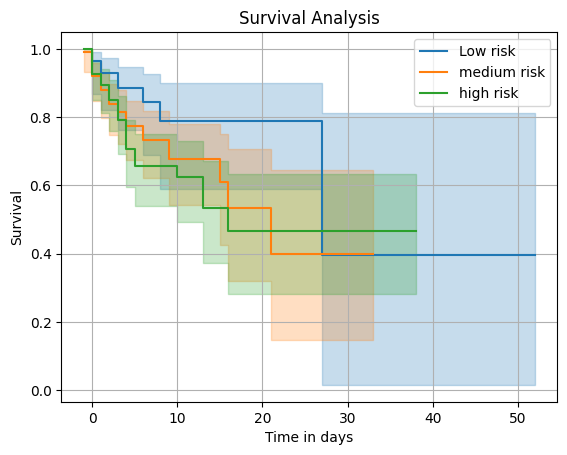

          removed  observed  censored  entrance  at_risk  survival prob
event_at                                                               
-1.0            1         0         1        96       96       1.000000
 0.0            9         7         2         0       95       0.926316
 3.0           16         5        11         0       72       0.790323
 4.0           13         6         7         0       56       0.705646
 5.0            7         3         4         0       43       0.656414
 6.0            6         0         6         0       36       0.656414
 7.0            3         0         3         0       30       0.656414
 8.0            3         0         3         0       27       0.656414
 9.0            4         0         4         0       24       0.656414
 10.0           3         1         2         0       20       0.623594
 11.0           2         0         2         0       17       0.623594
 12.0           1         0         1         0       15       0

In [79]:
## Model initiation
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
ax = plt.subplot(111)
subcohort=df_s_pred_perc[df_s_pred_perc['cohort']=='test']
for per_range in [['Low risk',0,0.3],['medium risk',0.3,0.7],['high risk',0.7,1]]:
    [subset,from_p,to_p]=per_range
    sub_per=subcohort[subcohort['percentile_from_ref'].between(from_p,to_p,inclusive='left')]
    t = sub_per['TTE']
    l = sub_per['Label']
    kmf.fit(t,l, label=subset)
    kmf.plot(title='Survival Analysis', ax=ax)#, at_risk_counts =True)
    plt.ylabel('Survival')
    plt.xlabel('Time in days')
    plt.grid(True)
plt.show()

table = kmf.event_table
table['survival prob'] = kmf.survival_function_
print(table.sample(n=20).sort_values(by='event_at'))

In [82]:
#### calculate clinically relevant metrics
cohorts_preds_surv=[]
for cohort in df_s_pred_perc['cohort'].unique():
    subset_surv_pred=df_s_pred_perc[df_s_pred_perc['cohort']== cohort]
    for t in [1,2,3,5,7,14,21,30]:
        true_label=((subset_surv_pred['Label']==1)&(subset_surv_pred['TTE']<=t)).astype(float)
        cohorts_preds_surv.append([cohort+'_t'+str(t),true_label,subset_surv_pred['percentile_from_ref']])




# df_metrics_surv[['dataset', 'day_window']]= df_metrics_surv['Cohort'].str.split('_t', expand=True)
# df_metrics_surv['day_window']=df_metrics_surv['day_window'].astype(int)
# df_metrics_surv

In [84]:
# df_metrics_surv.groupby('dataset')[['day_window','AUROC']].plot(x='day_window')